## To Do

Clean up the tweets - remove stopwords  <br />
See if it helps to apply a lematiser and to use NLTK to make sure words are spelled correctly  <br />
Remove hashtags and @ <br />
Make the colours of the chart be determined by the polarity <br />

In [4]:
import csv
from datetime import datetime

import pandas as pd
import tweepy

from textblob import TextBlob
import matplotlib.pyplot as plt
from matplotlib import gridspec

from statistics import mean 

# # Enter your Twitter API credentials and uncomment
# consumer_key = "<Your credential here>"
# consumer_secret = "<Your credential here>"
# access_key = "<Your credential here>"
# access_secret = "<Your credential here>"



In [5]:

def user_tweets(screen_name, tweet_mode='extended', multiple_users = False):
    # Get most recent 3240 tweets of the user and return them as a dataframe. Save as a csv if a single user 
    # (possible to integrate this procedure into one that looks up multiple users)

    now = datetime.now()
    dt_string = now.strftime("%Y%m%d_%H%M")
    project_filename = screen_name + "_" + dt_string + ".csv"
    filepath = "outputs//" + project_filename

    # authorize twitter, initialize tweepy
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api = tweepy.API(auth)

    # initialize a list to hold all the tweepy Tweets
    alltweets = []

    # make initial request for most recent tweets (200 is the maximum allowed count)
    new_tweets = api.user_timeline(screen_name=screen_name, count=200,tweet_mode=tweet_mode)

    # save most recent tweets
    alltweets.extend(new_tweets)

    # save the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1

    # keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) > 0:
        # print(f"getting tweets before {oldest}")

        # all subsequent requests use the max_id param to prevent duplicates
        new_tweets = api.user_timeline(
            screen_name=screen_name, count=200, max_id=oldest,tweet_mode=tweet_mode
        )

        # save most recent tweets
        alltweets.extend(new_tweets)

        # update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1

    # transform the tweets into a 2D array 
    outtweets = [[tweet.id_str, tweet.user.name, tweet.user.screen_name, tweet.created_at, tweet.full_text,
                  tweet.retweeted, tweet.in_reply_to_screen_name] for tweet in alltweets]

    df = pd.DataFrame(outtweets)
    df.columns = ['ID', 'Name', 'Screen Name', 'DateTime', 'Text', 'Retweeted', 'Replying To']    
    
    if multiple_users == False:
        df.to_csv(filepath)

    return df

def group_tweets(users, tweet_mode='extended', multiple_users = True):
    #Takes a list of usernames as an input and returns a dataframe that is all tweets of all of these users

    now = datetime.now()
    dt_string = now.strftime("%Y%m%d_%H%M")
    project_filename = "multiple_users_" + dt_string + ".csv"
    filepath = "outputs//" + project_filename    
    
    df_list = []
    
    for i in range(len(users)):
        screen_name = users[i]
        df_name = 'df'+str(i)
        try:
            df_name = user_tweets(screen_name, tweet_mode='extended', multiple_users = True)
            df_list.append(df_name)
        except:
            print("Failed to extract for "+screen_name)
            continue
            
    joined_df = pd.concat(df_list)
    
    joined_df.to_csv(filepath)
    
    return joined_df

In [6]:
user_list = ['CGDev', 'EconMitch', 'charlesjkenny', 'glassmanamanda','MasoodCGD']

joint_df = group_tweets(user_list)

In [7]:
biden_df = user_tweets('JoeBiden', tweet_mode='extended')
biden_df.head()

,ID,Name,Screen Name,DateTime,Text,Retweeted,Replying To
0,1370411955173912576,Joe Biden,JoeBiden,2021-03-12 16:30:45,85% of American households will get direct che...,False,None
1,1370184833226399744,Joe Biden,JoeBiden,2021-03-12 01:28:15,RT @POTUS: All adult Americans will be eligibl...,False,None
2,1370129856600670208,Joe Biden,JoeBiden,2021-03-11 21:49:48,"RT @POTUS: Before I took office, I promised yo...",False,None
3,1369749317628661760,Joe Biden,JoeBiden,2021-03-10 20:37:40,"RT @WhiteHouse: From $1,400 checks and unemplo...",False,None
4,1369739522263617539,Joe Biden,JoeBiden,2021-03-10 19:58:45,RT @POTUS: Help is here. https://t.co/urZCiigeS1,False,None


In [8]:
def check_text(text,terms, block_terms=[], terms_type=all, block_terms_type=any):

    if type(terms) is str:
        cond1 = terms in text
    else:
        cond1 = terms_type(term.lower() in text.lower() for term in terms)
    
    if len(block_terms) == 0:
        cond2 = True
    else:
        if type(block_terms) is str:
            cond2 = not (block_terms in text)
        else:
            cond2 = not( block_terms_type(term.lower() in text.lower() for term in block_terms))
            
    return cond1 and cond2


def tweet_filter(df, terms, block_terms=[], column_name="Text", terms_type=all, block_terms_type=any):
    # returns a dataframe containing only the tweets that contain terms and do not contain block terms

    unfiltered_list = list(df[column_name])
    
    if terms == []:
        boolean_list = [True for i in range(len(unfiltered_list))]      
    else:
        boolean_list = []          
        for i in range(len(unfiltered_list)):
            tweet = unfiltered_list[i]
            boolean_list.append(check_text(tweet, terms, block_terms, terms_type, block_terms_type))

    boolean_series = pd.Series(boolean_list)    
    df_new = df
    df['Boolean'] = boolean_series
    
    df = df[df_new['Boolean'] == True]
    df_new = df.drop(['Boolean'],axis=1)

    
    return df_new

def sentiment_df(df, terms, block_terms=[], column_name="Text", terms_type=all, block_terms_type=any):
    # Take a dataframe of tweets and creates a new one with only tweets containing terms and adds new columns,
    # showing polarity and subjectivity of the tweets

    df = tweet_filter(df, terms, block_terms, column_name, terms_type, block_terms_type)
    
    tweets = list(df[column_name])

    polarity_list = []
    subjectivity_list = []
    
    for tweet in tweets:
        sentiment = TextBlob(tweet)
        tweet_polarity = sentiment.polarity
        tweet_subjectivity = sentiment.subjectivity
        polarity_list.append(tweet_polarity)
        subjectivity_list.append(tweet_subjectivity)
           
    df['Polarity'] = polarity_list    
    df['Subjectivity'] = subjectivity_list

    return df



In [9]:
def sentiment_chart(df, terms, block_terms=[], column_name="Text", terms_type=all, block_terms_type=any, include_all = True,
                   multiple_users = False, chart_dpi = 600, save= True, labels=True):

    
    if multiple_users == True:
        username = str(df['Name'].nunique())+" users" 
        screen_name = 'Multiple Tweeters'
    else:
        username = df.iloc[0]['Name']
        screen_name = df.iloc[1]['Screen Name']

    # Filename parameters for saving the chart
    now = datetime.now()
    dt_string = now.strftime("%Y%m%d_%H%M")
    project_filename = screen_name + "_" + dt_string + ".png"
    filepath = "outputs//" + project_filename            
        
        
    pie_labels = ["Negative", "Neutral", "Positive"]  
    colors = ['lightcoral', 'gold', 'yellowgreen']
    
    if type(terms) is str:
        if include_all == True:
            terms = ["All Tweets",terms]
            numcharts = 2
        else:
            numcharts = 1
    else:
        if include_all == True:
            terms.insert(0,"All Tweets")
        numcharts = len(terms)        

        
    chart_index = numcharts-1
    
    chart_structures = [[1,1],[1,2],[1,3],[2,3],[2,3],[2,3],[3,3],[3,3],[3,3]]
    chart_indices = [[111],[121,122],[131,132,133],[231,232,233,234],[231,232,233,234,235],[231,232,233,234,235,236],[331,332,333,334,335,336,337],[331,332,333,334,335,336,337,338],[331,332,333,334,335,336,337,338,339]]
    
    chart_structure = chart_structures[numcharts-1]
    chart_index = chart_indices[numcharts-1]
    
    cs_row = chart_structure[0] 
    cs_col = chart_structure[1] 
 
    fig, ax = plt.subplots(cs_row,cs_col, figsize = (22.5,9))

    for i in range(numcharts):
        chart_position = chart_indices[numcharts-1][i]
        
        if type(terms) is str and include_all == False:
            term = terms
        else:
            term = terms[i]
            
        print
        
        if include_all == True and i == 0:
            term_df = sentiment_df(df, terms=[])
        else:
            term_df = sentiment_df(df, terms=term)

        tweets_text = list(term_df['Text'])
        tweets_polarity = list(term_df['Polarity'])
        numtweets = len(tweets_text)
        
        pos_tweet = tweets_text[tweets_polarity.index(max(tweets_polarity))]     
        
        polarity_list = list(term_df['Polarity'])
        subjectivity_list = list(term_df['Subjectivity'])
        
        subjectivity = mean(subjectivity_list)*100
        subjectivity = round(subjectivity, 2)

        polarity_values = [0, 0, 0]

        #Categorize each review
        for j in range(len(polarity_list)):
            polar_score = polarity_list[j]

            #Custom formula to convert polarity 
            scaled_polar_score = round(( polar_score + 1 ) * 3 ) % 3

            #add the summary array
            polarity_values[scaled_polar_score] += 1

        plt.subplot(chart_position)
        
        plt.pie(polarity_values, labels=pie_labels, colors=colors, autopct='%1.1f%%', startangle=140) 

        if term == 'All Tweets':
            title_term = 'All Tweets'
        else:
            title_term = "'"+term + "'" 
        
        if labels == True:
            subjectivity_marker = ": Subjectivity = "+str(subjectivity)+"%"
            if term == 'All Tweets':
                title_term = 'All Tweets'
            else:
                title_term = "'"+term + "'" 
            plt.title(title_term+" ("+str(numtweets)+" tweets) "+subjectivity_marker,fontsize=15)

            
            
    
    if labels == True:
        fig.suptitle("Tweet Sentiments for "+screen_name+" ("+username+")",fontsize=20)


#     plt.tight_layout()    
    if save == True:
        plt.savefig(filepath, dpi = chart_dpi)
    plt.show()
#     plt.draw()
    
# sentiment_chart(mitch_df, 'Tottenham', include_all = False, chart_dpi=1800, save= True, labels=True) 

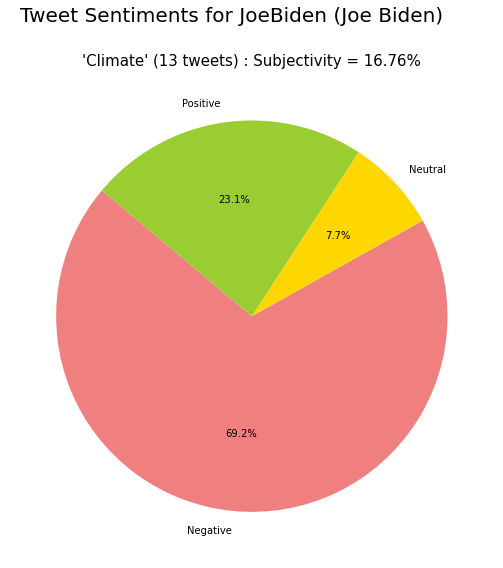

In [10]:
sentiment_chart(biden_df, 'Climate', include_all = False, chart_dpi=1800, save= False, labels=True) 

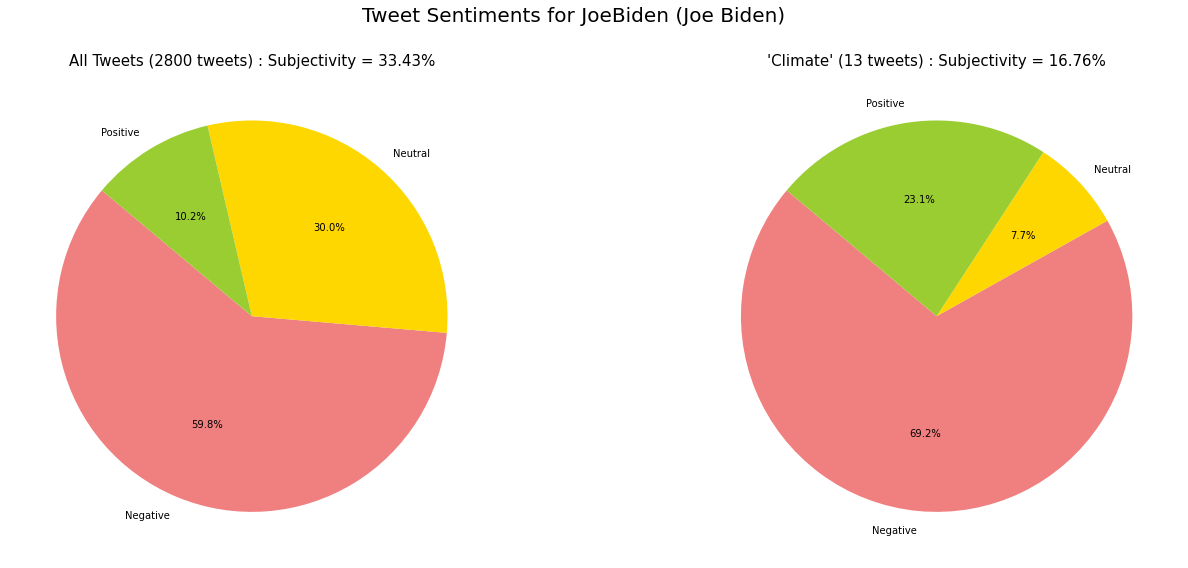

In [11]:
sentiment_chart(biden_df, 'Climate', include_all = True, chart_dpi=1800, save = False) 

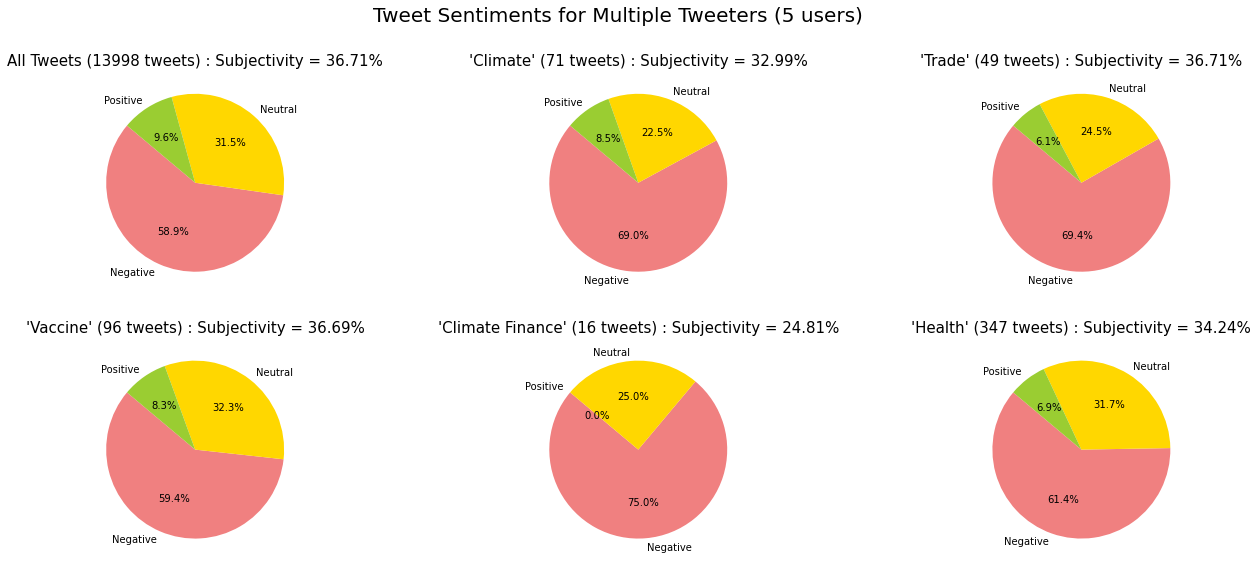

In [12]:
topics = ['Climate', 'Trade', 'Vaccine', 'Climate Finance', 'Health']
sentiment_chart(joint_df, topics, multiple_users = True, chart_dpi=1800, save = False) 